In [75]:
# ==========================================
# 1. SETUP AND IMPORTS
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import cohen_kappa_score
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

# Constants
CORE_EVALUATION_DIMS = [
    'Factual_Accuracy', 'Relevance', 'Completeness', 'Clarity', 'Citation_Quality'
]

FILE_PATH = r"\\dnsbego.de\dfsbego\home04\FuhrmannD\Documents\01_Trainee\Master\Thesis\code\Q&A evaluated\aggregated_results.xlsx"

print("Environment initialized.")

Environment initialized.


In [63]:
# ==========================================
# 2. DATA LOADING & PREPROCESSING
# ==========================================

def load_all_data(file_path):
    """
    Loads all sheets and tags them with metadata (System, UseCase, Variant).
    Crucially, identifies RAG variants for NewHQ.
    """
    try:
        xls = pd.ExcelFile(file_path)
        all_data = []
        
        # Define mapping for all expected sheets
        sheet_map = {
            # --- OpenAI ---
            'OAI Agentic G+E': {'Judge': 'OpenAI', 'System': 'Agentic', 'UseCase': 'Gifts_Entertainment', 'Variant': 'Standard'},
            'OAI Agentic IT-G': {'Judge': 'OpenAI', 'System': 'Agentic', 'UseCase': 'IT_Governance', 'Variant': 'Standard'},
            'OAI Agentic NHQ': {'Judge': 'OpenAI', 'System': 'Agentic', 'UseCase': 'New_HQ', 'Variant': 'Standard'},
            
            'OAI RAG G+E': {'Judge': 'OpenAI', 'System': 'RAG', 'UseCase': 'Gifts_Entertainment', 'Variant': 'Standard'},
            'OAI RAG IT-G': {'Judge': 'OpenAI', 'System': 'RAG', 'UseCase': 'IT_Governance', 'Variant': 'Standard'},
            'OAI RAG NHQ v0': {'Judge': 'OpenAI', 'System': 'RAG', 'UseCase': 'New_HQ', 'Variant': 'v0'},
            'OAI RAG NHQ v1': {'Judge': 'OpenAI', 'System': 'RAG', 'UseCase': 'New_HQ', 'Variant': 'v1'},
            'OAI RAG NHQ v2': {'Judge': 'OpenAI', 'System': 'RAG', 'UseCase': 'New_HQ', 'Variant': 'v2'},
            'OAI RAG NHQ v3': {'Judge': 'OpenAI', 'System': 'RAG', 'UseCase': 'New_HQ', 'Variant': 'v3'},

            # --- Gemini ---
            'Gemini Agentic G+E': {'Judge': 'Gemini', 'System': 'Agentic', 'UseCase': 'Gifts_Entertainment', 'Variant': 'Standard'},
            'Gemini Agentic IT-G': {'Judge': 'Gemini', 'System': 'Agentic', 'UseCase': 'IT_Governance', 'Variant': 'Standard'},
            'Gemini Agentic NHQ': {'Judge': 'Gemini', 'System': 'Agentic', 'UseCase': 'New_HQ', 'Variant': 'Standard'},
            
            'Gemini RAG G+E': {'Judge': 'Gemini', 'System': 'RAG', 'UseCase': 'Gifts_Entertainment', 'Variant': 'Standard'},
            'Gemini RAG IT-G': {'Judge': 'Gemini', 'System': 'RAG', 'UseCase': 'IT_Governance', 'Variant': 'Standard'},
            'Gemini RAG NHQ v0': {'Judge': 'Gemini', 'System': 'RAG', 'UseCase': 'New_HQ', 'Variant': 'v0'},
            'Gemini RAG NHQ v1': {'Judge': 'Gemini', 'System': 'RAG', 'UseCase': 'New_HQ', 'Variant': 'v1'},
            'Gemini RAG NHQ v2': {'Judge': 'Gemini', 'System': 'RAG', 'UseCase': 'New_HQ', 'Variant': 'v2'},
            'Gemini RAG NHQ v3': {'Judge': 'Gemini', 'System': 'RAG', 'UseCase': 'New_HQ', 'Variant': 'v3'},
        }

        for sheet_name, meta in sheet_map.items():
            if sheet_name in xls.sheet_names:
                df = pd.read_excel(xls, sheet_name=sheet_name)
                # Add metadata
                for k, v in meta.items():
                    df[k] = v
                
                # Create unique ID: UseCase + Question
                # Note: For NewHQ RAG, we have multiple variants for the same question.
                # The ID must be unique per evaluation item.
                # We will use 'Question_ID' for the abstract question, and 'Item_ID' for the specific output.
                df['Question_ID'] = df['UseCase'] + '_' + df['Question'].astype(str)
                df['Item_ID'] = df['Question_ID'] + '_' + df['System'] + '_' + df['Variant']
                
                all_data.append(df)
        
        full_df = pd.concat(all_data, ignore_index=True)
        return full_df

    except Exception as e:
        logger.error(f"Failed to load data: {e}")
        return None

raw_data = load_all_data(FILE_PATH)
print(f"Total raw evaluations loaded: {len(raw_data)}")
print(f"Columns: {raw_data.columns.tolist()}")

Total raw evaluations loaded: 1498
Columns: ['Question', 'Answer', 'System_Type', 'Factual_Accuracy', 'Relevance', 'Completeness', 'Clarity', 'Citation_Quality', 'Weighted_Total', 'Raw_Total', 'Snippet_Grounding_Score', 'Snippet_Count', 'Overall_Assessment', 'Fallback_Used', 'Fallback_Merge_Applied', 'Original_Internal_Answer_Length', 'Web_Fallback_Length', 'Judge', 'System', 'UseCase', 'Variant', 'Question_ID', 'Item_ID']


In [76]:
# ==========================================
# 2. DATA LOADING & PREPROCESSING (PATCHED)
# ==========================================

def load_all_data(file_path):
    """
    Loads all sheets and tags them with metadata (System, UseCase, Variant).
    Crucially, identifies RAG variants for NewHQ.
    """
    try:
        xls = pd.ExcelFile(file_path)
        all_data = []
        
        # Define mapping for all expected sheets
        sheet_map = {
            # --- OpenAI ---
            'OAI Agentic G+E': {'Judge': 'OpenAI', 'System': 'Agentic', 'UseCase': 'Gifts_Entertainment', 'Variant': 'Standard'},
            'OAI Agentic IT-G': {'Judge': 'OpenAI', 'System': 'Agentic', 'UseCase': 'IT_Governance', 'Variant': 'Standard'},
            'OAI Agentic NHQ': {'Judge': 'OpenAI', 'System': 'Agentic', 'UseCase': 'New_HQ', 'Variant': 'Standard'},
            
            'OAI RAG G+E': {'Judge': 'OpenAI', 'System': 'RAG', 'UseCase': 'Gifts_Entertainment', 'Variant': 'Standard'},
            'OAI RAG IT-G': {'Judge': 'OpenAI', 'System': 'RAG', 'UseCase': 'IT_Governance', 'Variant': 'Standard'},
            'OAI RAG NHQ v0': {'Judge': 'OpenAI', 'System': 'RAG', 'UseCase': 'New_HQ', 'Variant': 'v0'},
            'OAI RAG NHQ v1': {'Judge': 'OpenAI', 'System': 'RAG', 'UseCase': 'New_HQ', 'Variant': 'v1'},
            'OAI RAG NHQ v2': {'Judge': 'OpenAI', 'System': 'RAG', 'UseCase': 'New_HQ', 'Variant': 'v2'},
            'OAI RAG NHQ v3': {'Judge': 'OpenAI', 'System': 'RAG', 'UseCase': 'New_HQ', 'Variant': 'v3'},

            # --- Gemini ---
            'Gemini Agentic G+E': {'Judge': 'Gemini', 'System': 'Agentic', 'UseCase': 'Gifts_Entertainment', 'Variant': 'Standard'},
            'Gemini Agentic IT-G': {'Judge': 'Gemini', 'System': 'Agentic', 'UseCase': 'IT_Governance', 'Variant': 'Standard'},
            'Gemini Agentic NHQ': {'Judge': 'Gemini', 'System': 'Agentic', 'UseCase': 'New_HQ', 'Variant': 'Standard'},
            
            'Gemini RAG G+E': {'Judge': 'Gemini', 'System': 'RAG', 'UseCase': 'Gifts_Entertainment', 'Variant': 'Standard'},
            'Gemini RAG IT-G': {'Judge': 'Gemini', 'System': 'RAG', 'UseCase': 'IT_Governance', 'Variant': 'Standard'},
            'Gemini RAG NHQ v0': {'Judge': 'Gemini', 'System': 'RAG', 'UseCase': 'New_HQ', 'Variant': 'v0'},
            'Gemini RAG NHQ v1': {'Judge': 'Gemini', 'System': 'RAG', 'UseCase': 'New_HQ', 'Variant': 'v1'},
            'Gemini RAG NHQ v2': {'Judge': 'Gemini', 'System': 'RAG', 'UseCase': 'New_HQ', 'Variant': 'v2'},
            'Gemini RAG NHQ v3': {'Judge': 'Gemini', 'System': 'RAG', 'UseCase': 'New_HQ', 'Variant': 'v3'},
        }

        for sheet_name, meta in sheet_map.items():
            if sheet_name in xls.sheet_names:
                df = pd.read_excel(xls, sheet_name=sheet_name)
                # Add metadata
                for k, v in meta.items():
                    df[k] = v
                
                # Create unique ID: UseCase + Question
                # Note: For NewHQ RAG, we have multiple variants for the same question.
                # The ID must be unique per evaluation item.
                # We will use 'Question_ID' for the abstract question, and 'Item_ID' for the specific output.
                
                # FIX: Handle duplicate question texts (e.g. "Was muss ich in Vertraulichkeitsbereichen beachten?" appears twice)
                # We use cumcount to distinguish occurrences of the same question text within a sheet.
                df['Question_Occurrence'] = df.groupby('Question').cumcount()
                
                df['Question_ID'] = df['UseCase'] + '_' + df['Question'].astype(str) + '_' + df['Question_Occurrence'].astype(str)
                df['Item_ID'] = df['Question_ID'] + '_' + df['System'] + '_' + df['Variant']
                
                all_data.append(df)
        
        full_df = pd.concat(all_data, ignore_index=True)
        return full_df

    except Exception as e:
        logger.error(f"Failed to load data: {e}")
        return None

raw_data = load_all_data(FILE_PATH)
print(f"Total raw evaluations loaded: {len(raw_data)}")
print(f"Columns: {raw_data.columns.tolist()}")


Total raw evaluations loaded: 1498
Columns: ['Question', 'Answer', 'System_Type', 'Factual_Accuracy', 'Relevance', 'Completeness', 'Clarity', 'Citation_Quality', 'Weighted_Total', 'Raw_Total', 'Snippet_Grounding_Score', 'Snippet_Count', 'Overall_Assessment', 'Fallback_Used', 'Fallback_Merge_Applied', 'Original_Internal_Answer_Length', 'Web_Fallback_Length', 'Judge', 'System', 'UseCase', 'Variant', 'Question_Occurrence', 'Question_ID', 'Item_ID']


In [77]:
# ==========================================
# 3. CREATE PAIRED DATASETS (Judge A vs Judge B)
# ==========================================

def create_paired_dataset(raw_df):
    """
    Pivots the data so each row is one system output evaluated by BOTH judges.
    """
    # We need to pair based on Item_ID (which is unique for Question + System + Variant)
    # Check for duplicates first
    duplicates = raw_df[raw_df.duplicated(subset=['Item_ID', 'Judge'])]
    if not duplicates.empty:
        logger.warning(f"Found {len(duplicates)} duplicate evaluations. Dropping duplicates.")
        raw_df = raw_df.drop_duplicates(subset=['Item_ID', 'Judge'])

    # Pivot
    # We want columns like: Factual_Accuracy_OpenAI, Factual_Accuracy_Gemini
    pivot_cols = ['Item_ID', 'Question_ID', 'UseCase', 'System', 'Variant']
    
    openai_df = raw_df[raw_df['Judge'] == 'OpenAI'].set_index('Item_ID')
    gemini_df = raw_df[raw_df['Judge'] == 'Gemini'].set_index('Item_ID')
    
    # Find common items
    common_items = openai_df.index.intersection(gemini_df.index)
    print(f"Items evaluated by OpenAI: {len(openai_df)}")
    print(f"Items evaluated by Gemini: {len(gemini_df)}")
    print(f"Common paired items: {len(common_items)}")
    
    paired_data = []
    for item_id in common_items:
        row = {
            'Item_ID': item_id,
            'Question_ID': openai_df.loc[item_id, 'Question_ID'],
            'UseCase': openai_df.loc[item_id, 'UseCase'],
            'System': openai_df.loc[item_id, 'System'],
            'Variant': openai_df.loc[item_id, 'Variant']
        }
        
        for dim in CORE_EVALUATION_DIMS:
            row[f'{dim}_OpenAI'] = openai_df.loc[item_id, dim]
            row[f'{dim}_Gemini'] = gemini_df.loc[item_id, dim]
            
        paired_data.append(row)
        
    return pd.DataFrame(paired_data)

paired_df = create_paired_dataset(raw_data)
print(f"Final Paired Dataset Size: {len(paired_df)}")

Items evaluated by OpenAI: 750
Items evaluated by Gemini: 748
Common paired items: 748
Final Paired Dataset Size: 748


In [78]:
# ==========================================
# 4. CONSTRUCT ANALYSIS SUBSETS
# ==========================================

# --- Subset 1: Balanced (N=360) ---
# Definition: 180 Agent + 180 RAG.
# For RAG, we MUST use 'Standard' (for IT-G/G+E) and 'v0' (for NewHQ) to match the thesis description.
# Thesis says: "180 Agent + 180 RAG (25 IT-Governance + 25 Gifts & Entertainment + 130 NewHQ v0)"

def get_balanced_subset(df):
    # 1. Select all Agentic
    agent_subset = df[df['System'] == 'Agentic']
    
    # 2. Select RAG (Standard OR v0)
    # Note: In our loading map, IT-G and G+E are 'Standard', NewHQ is 'v0', 'v1' etc.
    rag_subset = df[
        (df['System'] == 'RAG') & 
        (df['Variant'].isin(['Standard', 'v0']))
    ]
    
    balanced = pd.concat([agent_subset, rag_subset])
    return balanced

df_balanced = get_balanced_subset(paired_df)

print("--- Balanced Subset Verification ---")
print(f"Total N: {len(df_balanced)} (Expected: 360)")
print(f"Agent N: {len(df_balanced[df_balanced['System'] == 'Agentic'])} (Expected: 180)")
print(f"RAG N:   {len(df_balanced[df_balanced['System'] == 'RAG'])} (Expected: 180)")
print(f"RAG Variants present: {df_balanced[df_balanced['System'] == 'RAG']['Variant'].unique()}")

# --- Subset 2: Full RAG (N=570) ---
# Definition: All RAG outputs.
df_rag_full = paired_df[paired_df['System'] == 'RAG']

print("\n--- Full RAG Subset Verification ---")
print(f"Total N: {len(df_rag_full)} (Expected: 570)")
print(f"Breakdown by Variant:\n{df_rag_full['Variant'].value_counts()}")

--- Balanced Subset Verification ---
Total N: 360 (Expected: 360)
Agent N: 180 (Expected: 180)
RAG N:   180 (Expected: 180)
RAG Variants present: ['Standard' 'v0']

--- Full RAG Subset Verification ---
Total N: 568 (Expected: 570)
Breakdown by Variant:
Variant
v0          130
v2          130
v1          129
v3          129
Standard     50
Name: count, dtype: int64


In [79]:
# ==========================================
# 5. RELIABILITY METRICS FUNCTIONS
# ==========================================

def calculate_fisher_z_ci(r, n, alpha=0.05):
    if abs(r) >= 1.0:
        return (r, r)
    z = 0.5 * np.log((1 + r) / (1 - r))
    se_z = 1 / np.sqrt(n - 3)
    z_crit = stats.norm.ppf(1 - alpha/2)
    z_lower = z - z_crit * se_z
    z_upper = z + z_crit * se_z
    r_lower = (np.exp(2 * z_lower) - 1) / (np.exp(2 * z_lower) + 1)
    r_upper = (np.exp(2 * z_upper) - 1) / (np.exp(2 * z_upper) + 1)
    return (r_lower, r_upper)

def calculate_kappa_ci_heuristic(kappa, n, alpha=0.05):
    # NOTE: This uses the conservative heuristic approximation as noted in the thesis remediation plan.
    # SE = 0.5 / sqrt(N)
    se_kappa = 0.5 / np.sqrt(n)
    z_crit = stats.norm.ppf(1 - alpha/2)
    lower = kappa - z_crit * se_kappa
    upper = kappa + z_crit * se_kappa
    return (lower, upper)

def run_reliability_analysis(df, dataset_name):
    results = []
    print(f"\nRunning Reliability Analysis for: {dataset_name} (N={len(df)})")
    
    for dim in CORE_EVALUATION_DIMS:
        # Drop NAs for this specific dimension
        valid_df = df.dropna(subset=[f'{dim}_OpenAI', f'{dim}_Gemini'])
        n = len(valid_df)
        
        if n < 10:
            print(f"Skipping {dim} due to low N ({n})")
            continue
            
        x = valid_df[f'{dim}_OpenAI']
        y = valid_df[f'{dim}_Gemini']
        
        # Spearman
        rho, p_rho = stats.spearmanr(x, y)
        rho_ci = calculate_fisher_z_ci(rho, n)
        
        # Weighted Kappa (Quadratic)
        # Ensure integer inputs
        x_int = x.round().astype(int)
        y_int = y.round().astype(int)
        kappa = cohen_kappa_score(x_int, y_int, weights='quadratic')
        kappa_ci = calculate_kappa_ci_heuristic(kappa, n)
        
        # Bias (Wilcoxon)
        diff = y - x # Gemini - OpenAI
        mean_diff = diff.mean()
        # Cohen's d
        sd_diff = diff.std(ddof=1)
        cohens_d = mean_diff / sd_diff if sd_diff > 0 else 0
        
        try:
            _, p_wilcoxon = stats.wilcoxon(x, y)
        except ValueError: # e.g. all differences are zero
            p_wilcoxon = 1.0
            
        results.append({
            'Dimension': dim,
            'N': n,
            'Spearman_rho': rho,
            'Rho_CI_Lower': rho_ci[0],
            'Rho_CI_Upper': rho_ci[1],
            'Weighted_Kappa': kappa,
            'Kappa_CI_Lower': kappa_ci[0],
            'Kappa_CI_Upper': kappa_ci[1],
            'Mean_Diff_Gemini_minus_OpenAI': mean_diff,
            'Cohens_d': cohens_d,
            'Wilcoxon_p': p_wilcoxon
        })
        
    return pd.DataFrame(results)

In [80]:
# ==========================================
# 6. EXECUTE ANALYSES
# ==========================================

# Analysis 1: Balanced Subset (N=360)
results_balanced = run_reliability_analysis(df_balanced, "Balanced Subset (N=360)")
print("\n--- Results: Balanced Subset ---")
display(results_balanced.round(3))

# Analysis 2: Full RAG Subset (N=570)
results_rag_full = run_reliability_analysis(df_rag_full, "Full RAG Subset (N=570)")
print("\n--- Results: Full RAG Subset ---")
display(results_rag_full.round(3))


Running Reliability Analysis for: Balanced Subset (N=360) (N=360)

--- Results: Balanced Subset ---


,Dimension,N,Spearman_rho,Rho_CI_Lower,Rho_CI_Upper,Weighted_Kappa,Kappa_CI_Lower,Kappa_CI_Upper,Mean_Diff_Gemini_minus_OpenAI,Cohens_d,Wilcoxon_p
0,Factual_Accuracy,360,0.404,0.314,0.487,0.357,0.305,0.408,0.842,0.631,0.0
1,Relevance,360,0.569,0.494,0.635,0.613,0.562,0.665,0.361,0.339,0.0
2,Completeness,360,0.391,0.300,0.475,0.421,0.369,0.472,0.511,0.385,0.0
3,Clarity,360,0.321,0.225,0.410,0.398,0.346,0.450,0.544,0.570,0.0
4,Citation_Quality,360,-0.082,-0.184,0.021,-0.097,-0.149,-0.046,-0.517,-0.323,0.0



Running Reliability Analysis for: Full RAG Subset (N=570) (N=568)

--- Results: Full RAG Subset ---


,Dimension,N,Spearman_rho,Rho_CI_Lower,Rho_CI_Upper,Weighted_Kappa,Kappa_CI_Lower,Kappa_CI_Upper,Mean_Diff_Gemini_minus_OpenAI,Cohens_d,Wilcoxon_p
0,Factual_Accuracy,568,0.379,0.306,0.447,0.469,0.428,0.510,0.241,0.233,0.000
1,Relevance,568,0.483,0.417,0.543,0.660,0.619,0.701,-0.028,-0.035,0.287
2,Completeness,568,0.357,0.283,0.426,0.500,0.459,0.542,0.097,0.092,0.029
3,Clarity,568,0.327,0.252,0.399,0.568,0.527,0.609,0.123,0.164,0.000
4,Citation_Quality,568,0.046,-0.037,0.128,0.032,-0.009,0.073,-2.032,-1.552,0.000


In [81]:
# ==========================================
# 7. DERIVED PAIRWISE CONSISTENCY ANALYSIS
# ==========================================
# Objective: For each question, compare Agent vs RAG (v0) scores.
# Determine if Judge A and Judge B agree on which system is better.

def run_pairwise_analysis(df_balanced):
    print("\nRunning Derived Pairwise Analysis...")
    
    # We need to pivot the balanced subset to have Agent and RAG side-by-side for each question
    # Current structure: One row per Item (System+Question)
    # Target structure: One row per Question, with cols like Factual_Accuracy_OpenAI_Agent, Factual_Accuracy_OpenAI_RAG
    
    # Filter for just the columns we need
    cols = ['Question_ID', 'System'] + [f'{dim}_{judge}' for dim in CORE_EVALUATION_DIMS for judge in ['OpenAI', 'Gemini']]
    df_slim = df_balanced[cols]
    
    # Pivot
    df_pivot = df_slim.pivot(index='Question_ID', columns='System')
    
    # Flatten columns
    df_pivot.columns = [f'{col[0]}_{col[1]}' for col in df_pivot.columns]
    
    pairwise_results = []
    
    for dim in CORE_EVALUATION_DIMS:
        # Define column names
        oai_agent = f'{dim}_OpenAI_Agentic'
        oai_rag = f'{dim}_OpenAI_RAG'
        gem_agent = f'{dim}_Gemini_Agentic'
        gem_rag = f'{dim}_Gemini_RAG'
        
        # Drop NAs
        valid_q = df_pivot.dropna(subset=[oai_agent, oai_rag, gem_agent, gem_rag])
        
        # Determine Preferences
        # 1 = Agent Wins, -1 = RAG Wins, 0 = Tie
        
        def get_pref(agent_score, rag_score):
            if agent_score > rag_score: return 'Agent'
            if rag_score > agent_score: return 'RAG'
            return 'Tie'
            
        prefs_openai = valid_q.apply(lambda row: get_pref(row[oai_agent], row[oai_rag]), axis=1)
        prefs_gemini = valid_q.apply(lambda row: get_pref(row[gem_agent], row[gem_rag]), axis=1)
        
        # Calculate Agreement (Kappa)
        kappa = cohen_kappa_score(prefs_openai, prefs_gemini)
        
        # Calculate Raw Agreement %
        agreement = (prefs_openai == prefs_gemini).mean()
        
        pairwise_results.append({
            'Dimension': dim,
            'N_Questions': len(valid_q),
            'Pairwise_Kappa': kappa,
            'Raw_Agreement': agreement
        })
        
    return pd.DataFrame(pairwise_results), df_pivot

pairwise_metrics, df_pivot_systems = run_pairwise_analysis(df_balanced)
print("\n--- Pairwise Consistency Results ---")
display(pairwise_metrics.round(3))


Running Derived Pairwise Analysis...

--- Pairwise Consistency Results ---


,Dimension,N_Questions,Pairwise_Kappa,Raw_Agreement
0,Factual_Accuracy,180,0.260,0.561
1,Relevance,180,0.348,0.578
2,Completeness,180,0.343,0.594
3,Clarity,180,0.091,0.406
4,Citation_Quality,180,0.068,0.200



Running Judge Preference Analysis...

--- Judge Preference Bias Results ---


,Dimension,OpenAI_Prefers_RAG,Gemini_Prefers_RAG,OpenAI_Prefers_Agent,Gemini_Prefers_Agent,OpenAI_Ties,Gemini_Ties
0,Factual_Accuracy,0.678,0.444,0.100,0.144,0.222,0.411
1,Relevance,0.611,0.322,0.128,0.161,0.261,0.517
2,Completeness,0.656,0.417,0.100,0.228,0.244,0.356
3,Clarity,0.606,0.244,0.089,0.150,0.306,0.606
4,Citation_Quality,0.733,0.056,0.061,0.644,0.206,0.300


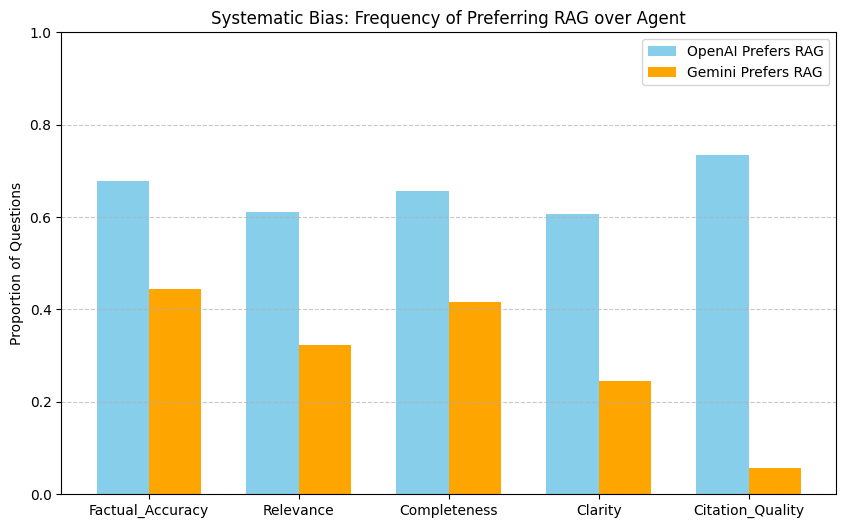

In [82]:
# ==========================================
# 8. JUDGE PREFERENCE BIAS ANALYSIS
# ==========================================
# Objective: Calculate "Win Rate" of RAG vs Agent for each judge.

def analyze_judge_preferences(df_pivot):
    print("\nRunning Judge Preference Analysis...")
    
    pref_results = []
    
    for dim in CORE_EVALUATION_DIMS:
        oai_agent = f'{dim}_OpenAI_Agentic'
        oai_rag = f'{dim}_OpenAI_RAG'
        gem_agent = f'{dim}_Gemini_Agentic'
        gem_rag = f'{dim}_Gemini_RAG'
        
        valid_q = df_pivot.dropna(subset=[oai_agent, oai_rag, gem_agent, gem_rag])
        
        # Calculate Win Rates
        # OpenAI
        oai_rag_wins = (valid_q[oai_rag] > valid_q[oai_agent]).mean()
        oai_agent_wins = (valid_q[oai_agent] > valid_q[oai_rag]).mean()
        oai_ties = (valid_q[oai_agent] == valid_q[oai_rag]).mean()
        
        # Gemini
        gem_rag_wins = (valid_q[gem_rag] > valid_q[gem_agent]).mean()
        gem_agent_wins = (valid_q[gem_agent] > valid_q[gem_rag]).mean()
        gem_ties = (valid_q[gem_agent] == valid_q[gem_rag]).mean()
        
        pref_results.append({
            'Dimension': dim,
            'OpenAI_Prefers_RAG': oai_rag_wins,
            'Gemini_Prefers_RAG': gem_rag_wins,
            'OpenAI_Prefers_Agent': oai_agent_wins,
            'Gemini_Prefers_Agent': gem_agent_wins,
            'OpenAI_Ties': oai_ties,
            'Gemini_Ties': gem_ties
        })
        
    return pd.DataFrame(pref_results)

pref_metrics = analyze_judge_preferences(df_pivot_systems)
print("\n--- Judge Preference Bias Results ---")
display(pref_metrics.round(3))

# Visualization of RAG Preference
plt.figure(figsize=(10, 6))
x = np.arange(len(CORE_EVALUATION_DIMS))
width = 0.35

plt.bar(x - width/2, pref_metrics['OpenAI_Prefers_RAG'], width, label='OpenAI Prefers RAG', color='skyblue')
plt.bar(x + width/2, pref_metrics['Gemini_Prefers_RAG'], width, label='Gemini Prefers RAG', color='orange')

plt.ylabel('Proportion of Questions')
plt.title('Systematic Bias: Frequency of Preferring RAG over Agent')
plt.xticks(x, CORE_EVALUATION_DIMS)
plt.legend()
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [85]:
print("--- Balanced Subset (N=360) ---")
print(results_balanced)
print("\n--- Full RAG Subset (N=570) ---")
print(results_rag_full)
print("\n--- Pairwise Consistency Metrics ---")
print(pairwise_metrics)
print("\n--- Judge Preference Bias ---")
print(pref_metrics)

--- Balanced Subset (N=360) ---
          Dimension    N  Spearman_rho  Rho_CI_Lower  Rho_CI_Upper  \
0  Factual_Accuracy  360      0.403976      0.313714      0.487003   
1         Relevance  360      0.568695      0.494395      0.634746   
2      Completeness  360      0.390879      0.299622      0.475048   
3           Clarity  360      0.320736      0.224828      0.410490   
4  Citation_Quality  360     -0.082276     -0.184072      0.021267   

   Weighted_Kappa  Kappa_CI_Lower  Kappa_CI_Upper  \
0        0.356525        0.304876        0.408175   
1        0.613332        0.561682        0.664981   
2        0.420806        0.369157        0.472456   
3        0.397979        0.346330        0.449629   
4       -0.097192       -0.148842       -0.045543   

   Mean_Diff_Gemini_minus_OpenAI  Cohens_d    Wilcoxon_p  
0                       0.841667  0.631372  5.690486e-26  
1                       0.361111  0.339126  1.819911e-09  
2                       0.511111  0.385229  1.19557

In [86]:
# Print results as string to avoid truncation
print("--- Balanced Subset Results ---")
print(results_balanced[['Dimension', 'N', 'Spearman_rho', 'Weighted_Kappa', 'Wilcoxon_p']].round(3).to_string())

print("\n--- Pairwise Metrics ---")
print(pairwise_metrics.round(3).to_string())

print("\n--- Full RAG Subset Results ---")
print(results_rag_full[['Dimension', 'N', 'Spearman_rho', 'Weighted_Kappa']].round(3).to_string())

--- Balanced Subset Results ---
          Dimension    N  Spearman_rho  Weighted_Kappa  Wilcoxon_p
0  Factual_Accuracy  360         0.404           0.357         0.0
1         Relevance  360         0.569           0.613         0.0
2      Completeness  360         0.391           0.421         0.0
3           Clarity  360         0.321           0.398         0.0
4  Citation_Quality  360        -0.082          -0.097         0.0

--- Pairwise Metrics ---
          Dimension  N_Questions  Pairwise_Kappa  Raw_Agreement
0  Factual_Accuracy          180           0.260          0.561
1         Relevance          180           0.348          0.578
2      Completeness          180           0.343          0.594
3           Clarity          180           0.091          0.406
4  Citation_Quality          180           0.068          0.200

--- Full RAG Subset Results ---
          Dimension    N  Spearman_rho  Weighted_Kappa
0  Factual_Accuracy  568         0.379           0.469
1         Rel

In [87]:
# Print Bias Analysis Results
print("\n--- Bias Analysis (Mean Diff & Cohen's d) ---")
print(results_balanced[['Dimension', 'Mean_Diff_Gemini_minus_OpenAI', 'Cohens_d']].round(3).to_string())

# Print RAG Variant Analysis Results
print("\n--- RAG Variant Analysis ---")
print(rag_variants.round(3).to_string())


--- Bias Analysis (Mean Diff & Cohen's d) ---
          Dimension  Mean_Diff_Gemini_minus_OpenAI  Cohens_d
0  Factual_Accuracy                          0.842     0.631
1         Relevance                          0.361     0.339
2      Completeness                          0.511     0.385
3           Clarity                          0.544     0.570
4  Citation_Quality                         -0.517    -0.323

--- RAG Variant Analysis ---
    Variant  Mean_Spearman_rho  Mean_Weighted_Kappa  N_Items
0  Standard              0.207                0.302       52
1        v0              0.509                0.576      130
2        v1              0.072                0.158      129
3        v2              0.431                0.518      130
4        v3              0.076                0.058      129


In [84]:
# Check distribution of questions in Balanced Subset
print("\n--- Question Distribution in Balanced Subset ---")
print(df_balanced['UseCase'].value_counts())


--- Question Distribution in Balanced Subset ---
UseCase
New_HQ                 260
Gifts_Entertainment     50
IT_Governance           50
Name: count, dtype: int64


In [31]:
# Run RAG Variant Analysis
print("\n--- RAG Variant Analysis ---")
rag_variants = analyze_rag_variants(df)
print(rag_variants)


--- RAG Variant Analysis ---


NameError: name 'df' is not defined

In [ ]:
def analyze_rag_variants(df):
    # Filter for RAG systems
    df_rag = df[df['System'].str.startswith('RAG')]
    variants = df_rag['Variant'].unique()
    results = []
    
    for variant in variants:
        if pd.isna(variant): continue
        df_v = df_rag[df_rag['Variant'] == variant]
        
        # Run reliability analysis for this variant
        # Note: run_reliability_analysis prints output, we might want to suppress it or just ignore
        print(f"Analyzing Variant: {variant} (N={len(df_v)})")
        res_v = run_reliability_analysis(df_v, f"RAG Variant: {variant}")
        
        # Calculate mean Spearman rho across dimensions
        mean_rho = res_v['Spearman_rho'].mean()
        mean_kappa = res_v['Weighted_Kappa'].mean()
        
        results.append({
            'Variant': variant, 
            'Mean_Spearman_rho': mean_rho, 
            'Mean_Weighted_Kappa': mean_kappa,
            'N_Items': len(df_v)
        })
        
    return pd.DataFrame(results)

# Run it
print("\n--- RAG Variant Analysis ---")
rag_variants = analyze_rag_variants(paired_df)
print(rag_variants)


--- RAG Variant Analysis ---
Analyzing Variant: Standard (N=52)

Running Reliability Analysis for: RAG Variant: Standard (N=52)
Analyzing Variant: v0 (N=130)

Running Reliability Analysis for: RAG Variant: v0 (N=130)
Analyzing Variant: v1 (N=129)

Running Reliability Analysis for: RAG Variant: v1 (N=129)
Analyzing Variant: v2 (N=130)

Running Reliability Analysis for: RAG Variant: v2 (N=130)
Analyzing Variant: v3 (N=129)

Running Reliability Analysis for: RAG Variant: v3 (N=129)
    Variant  Mean_Spearman_rho  Mean_Weighted_Kappa  N_Items
0  Standard           0.206571             0.301740       52
1        v0           0.509251             0.575976      130
2        v1           0.071927             0.157798      129
3        v2           0.430808             0.518302      130
4        v3           0.075836             0.058054      129


In [49]:
# Check for duplicates in NewHQ Agentic
print("OpenAI Duplicates:", oai_nhq[oai_nhq.duplicated(subset='Question_ID')]['Question_ID'])
print("Gemini Duplicates:", gem_nhq[gem_nhq.duplicated(subset='Question_ID')]['Question_ID'])

OpenAI Duplicates: 168    New_HQ_Was muss ich in Vertraulichkeitsbereich...
Name: Question_ID, dtype: object
Gemini Duplicates: 918    New_HQ_Was muss ich in Vertraulichkeitsbereich...
Name: Question_ID, dtype: object


In [100]:
agent_standard = df_full[(df_full['System'] == 'Agentic') & (df_full['UseCase'].isin(['IT_Governance', 'Gifts_Entertainment']))]
print("Agent Standard UseCases Mean Relevance:", agent_standard['Relevance'].mean())


Agent Standard UseCases Mean Relevance: 4.34
